---
# Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 6))
plt.rc('font', size=13)

---
# Acquire
---

## full data import

In [41]:
# %%time
# df = pd.read_csv('used_cars_data.csv')

In [43]:
# df.shape

---
Maybe only keep cities with a lot of data in TX
- San Antonio, 
- Houston
- Dallas
- Austin
- El Paso?
- Arlington (is this the Arlington in TX?)
- Fort Worth

In [44]:
# df = df[(df.city == 'San Antonio') |
#         (df.city == 'Houston') |
#         (df.city == 'Dallas') |
#         (df.city == 'Austin') |
#         (df.city == 'El Paso') |
#         (df.city == 'Arlington') |
#         (df.city == 'Fort Worth')]

In [45]:
# df.shape

---
Export .csv here to do rest of work with

In [46]:
# df.to_csv('texas_car_data.csv')

---
## Only TX cars import
---

In [274]:
%%time
df = pd.read_csv('texas_car_data.csv', index_col=0)

CPU times: user 3.19 s, sys: 354 ms, total: 3.54 s
Wall time: 3.59 s


In [ ]:
df = df.reset_index(drop=True) # reset index for this subset of the dataset

In [275]:
df.shape

(122842, 66)

In [276]:
df.head(1)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
139229,JHMFC1F73JX018575,37.4 in,NaN,NaN,NaN,Sedan,NaN,Fort Worth,32.0,NaN,...,CVT,Continuously Variable Transmission,t76411,Touring,NaN,FWD,Front-Wheel Drive,106.3 in,70.8 in,2018


---
# Prepare
---

## Quick clean for MVP

In [277]:
# just curious to see if this is even really necessary. How many duplicates even are there?
df.duplicated().sum()

0

In [278]:
df = df.drop_duplicates()

In [279]:
df.shape

(122842, 66)

In [280]:
df.dropna().shape
# cannot drop them all since all rows have at least one null value

(0, 66)

In [281]:
df.shape

(122842, 66)

---

## More nuanced prep involving imputation

In [282]:
def nulls_by_col(df):
    '''
    Takes in df and shows count of how many rows are null and percentage of total rows that are null
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = round(num_missing / rows * 100, 2)
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

In [283]:
nulls_cols = nulls_by_col(df)

In [284]:
nulls_cols[nulls_cols.percent_rows_missing > 50]

,num_rows_missing,percent_rows_missing
bed,121639,99.02
bed_height,104915,85.41
bed_length,104915,85.41
cabin,120703,98.26
combine_fuel_economy,122842,100.00
fleet,62167,50.61
frame_damaged,62167,50.61
has_accidents,62167,50.61
isCab,62167,50.61
is_certified,122842,100.00


In [285]:
nulls_cols[nulls_cols.percent_rows_missing > 50].shape

(16, 2)

**All of these columns will be dropped**

In [286]:
def nulls_by_row(df):
    '''
    Takes in df and shows count of how many columns are null and percentage of total columns that are null and value count of each unique combo
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = round(num_missing / df.shape[1] * 100, 2)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [287]:
nulls_rows = nulls_by_row(df)

In [288]:
nulls_rows[nulls_rows.percent_cols_missing > 50]

,num_cols_missing,percent_cols_missing,num_rows
30,34,51.52,1131
31,35,53.03,668
32,36,54.55,266
33,37,56.06,322
34,38,57.58,539
35,39,59.09,299
36,40,60.61,54
37,41,62.12,55
38,42,63.64,25


In [289]:
nulls_rows[nulls_rows.percent_cols_missing > 50].num_rows.sum()

3359

**3359 rows will be dropped (if we were looking at original df, but in function, columns are dropped first, so %s will change and less rows will be dropped)**

In [290]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.5):
    '''
    Takes in df and thresholds for null proportions in each column and row and returns df with only columns and rows below threshold
    '''
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [291]:
df.shape

(122842, 66)

In [292]:
%%time
df = handle_missing_values(df)

CPU times: user 417 ms, sys: 39.8 ms, total: 457 ms
Wall time: 461 ms


In [293]:
df.shape

(122816, 50)

In [294]:
122_842 - 122_816

26

In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122816 entries, 0 to 122841
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   back_legroom          122816 non-null  float64
 1   body_type             122357 non-null  object 
 2   city                  122816 non-null  object 
 3   city_fuel_economy     103714 non-null  float64
 4   engine_displacement   116188 non-null  float64
 5   franchise_dealer      122816 non-null  int64  
 6   front_legroom         122816 non-null  float64
 7   fuel_tank_volume      122816 non-null  float64
 8   fuel_type             119261 non-null  object 
 9   height                122816 non-null  float64
 10  highway_fuel_economy  103714 non-null  float64
 11  horsepower            116188 non-null  float64
 12  is_new                122816 non-null  int64  
 13  latitude              122816 non-null  float64
 14  length                116916 non-null  float64
 15  

---
#### Initial Ideas/Thoughts about columns:
- VIN
    - Keep as ID? Or just use pandas ID
    - Could use VIN to try to look up vehicle and get more data, but would be beyond scope of this project
    - Drop
- back_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - split, convert to float, impute with mean
- body-type
    - 9 categories
    - keep
- city
    - 7 cities
    - keep
- city_fuel_economy
    - looks like there are some outliers here
    - remove outliers and keep
- daysonmarket
    - Also has outliers (are they?)
    - Should I remove these?
    - Don't think it will be great predictor
    - Keep for now for future feature engineering
    - could be another predictor, but you won't have this until after car is sold, therefore could not be used to predict price
    - drop
- dealer_zip
    - 249 values
    - use lat and long instead or city
    - Drop
- description
    - long text description
    - drop
- engine_cylinders
    - 31 values
    - Maybe simpify just to number of cylinders?
    - Drop for now
    - With more time, I could pull out different categorical/numerical columns from this one column to add features, too much packed into one column
- engine_displacement
    - Maybe some outliers
    - keep for now
- engine_type
    - identical data to engine_cylinders
    - drop for now
- exterior_color
    - 4310 values
    - Could try to clean this column up but would take time
    - drop for now
    - listing color is better
- franchise_dealer
    - no nulls
    - bool
    - keep for now
        - convert to 1 or 0
- franchise_make
    - 39 values
    - The company that owns the franchise (dealership)
    - keep for now
    - Keep top 6 categories and classify all others as "other"
    - drop, other column pertains more pertinent info
- front_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - split, convert to float, impute with mean
- fuel_tank_volume
    - currently string
    - format and convert to float
    - keep converted version
- fuel_type
    - 7 categories
    - Keep for now
    - Maybe narrow down number of categories
        - gas or other?
- height
    - currently string, same process as fuel tank volume
    - keep for now
    - split, convert to float, impute with mean
 - highway_fuel_economy
     - keep
     - maybe remove outliers later
- horsepower
    - keep
    - outliers?
- interior_color
    - 4471 different colors here
    - Could clean up, not for MVP
    - drop
- is_new
    - about 50/50
    - whether or not vehicle waslaunched less than 2 years ago
    - no nulls
    - keep
        - convert to 1 or 0
- latitude
    - keep
- length
    - same process as height and fuel tank volume
    - keep
    - split, convert to float, impute with mean
- listed_date
    - convert to datetime
    - Add to days on market to get date sold
       - all cars were sold in Sep 2020, must have been filter of data being pulled
    - from date sold, create month sold and maybe year sold and add as a new feature
        - not useful since all cars sold on some month of same year
    - drop both columns used after feature is added
    - drop
- listing_color
    - not very many categories
    - keep for now
    - maybe group smaller categories into 'Other'
- listing_id
    - drop
- longitude
    - keep
- main_picture_url
    - url of main listing pic
    - drop
- major_options
    - list of customizable options added (upgrades)
    - can't leave in current format
    - could make new column of length to see how many upgrades each car has
    - could also use in syntax to create more features around whether or not the car has a feature (e.g. cruise control, leather seats, etc.)
    - stored as string
    - drop
    - could revisit and see how to convert to list
- make_name
    - car manufacturer
    - 61 different values
    - pick top groups and group others as 'Other'
    - keep
- maximum_seating
    - keep
    - split, convert to int
    - fill with median or mean
- mileage
    - not sure what is going on with this one
    - keep and remove outliers
- model_name
    - 881 values
    - drop for now
- power
    - combination for hp and rpm
    - info is contained in hp column
    - with more time could normalize and convert into single continuous variable
    - drop for now
- price
    - target
    - drop outliers?
- savings_amount
    - drop
- seller_rating
    - drop
- sp_id
    - drop
- sp_name
    - drop
- torque
    - drop
    - with more time could normalize and convert into single continuous variable
- transmission
    - keep
- transmission_display
    - too many categories
    - drop
- trimId
    - drop
- trim_name
    - drop
- wheel_system
    - keep
- wheel_system_display
    - same info as above
    - drop
- wheelbase
    - same process to pull out number
    - keep for now
- width
    - same process to pull out number
    - keep for now
- year
    - keep
    - outliers?

---

#### scratchpad area

In [708]:
df.year[df.year < 1950]

3589      1940
121414    1923
Name: year, dtype: int64

---
### Choose columns to keep/drop
---

In [356]:
# final list of cols to keep
cols_to_keep = [
    'body_type',
    'city',
    'city_fuel_economy',
    'daysonmarket',
    'engine_displacement',
    'franchise_dealer',
    'franchise_make',
    'fuel_tank_volume',
    'fuel_type',
    'height',
    'highway_fuel_economy',
    'horsepower',
    'latitude',
    'length',
    'listing_color',
    'longitude',
    'make_name',
    'maximum_seating',
    'mileage',
    'transmission',
    'wheel_system',
    'wheelbase',
    'width',
    'year'
]

---

In [771]:
df = pd.read_csv('texas_car_data.csv', index_col=0)
df = df.reset_index(drop=True) # reset index for this subset of the dataset
df = df.drop_duplicates()
df = handle_missing_values(df)

In [772]:
df.shape

(122816, 50)

In [773]:
# back legroom
df.back_legroom = df.back_legroom.str.split(' ', expand=True)[0]
df.back_legroom = pd.to_numeric(df.back_legroom, errors='coerce')
df.back_legroom = df.back_legroom.fillna(round(df.back_legroom.mean(),2))

In [774]:
df.shape

(122816, 50)

In [775]:
# # franchise_make
# top_six = ['Ford', 'Chevrolet', 'Toyota', 'Honda', 'Nissan', 'Jeep']

# df.franchise_make = df.franchise_make.apply(lambda x: x if x in top_six else 'Other')

# # df.franchise_make = np.where(df.franchise_make in top_six, df.franchise_make, 'Other')

In [776]:
df.shape

(122816, 50)

In [777]:
# front legroom
df.front_legroom = df.front_legroom.str.split(' ', expand=True)[0]
df.front_legroom = pd.to_numeric(df.front_legroom, errors='coerce')
df.front_legroom = df.front_legroom.fillna(round(df.front_legroom.mean(),2))

In [778]:
df.shape

(122816, 50)

In [779]:
# franchise_dealer
df.franchise_dealer = np.where(df.franchise_dealer == True, 1, 0)

In [780]:
df.shape

(122816, 50)

In [781]:
# fuel_tank_volume
df.fuel_tank_volume = df.fuel_tank_volume.str.split(' ', expand=True)[0]
df.fuel_tank_volume = pd.to_numeric(df.fuel_tank_volume, errors='coerce')
df.fuel_tank_volume = df.fuel_tank_volume.fillna(round(df.fuel_tank_volume.mean(),2))

In [782]:
df.shape

(122816, 50)

In [783]:
# height
df.height = df.height.str.split(' ', expand=True)[0]
df.height = pd.to_numeric(df.height, errors='coerce')
df.height = df.height.fillna(round(df.height.mean(),2))

In [784]:
df.shape

(122816, 50)

In [785]:
# is_new
df.is_new = np.where(df.is_new == True, 1, 0)

In [786]:
df.shape

(122816, 50)

In [787]:
# length
df.length = df.length.str.split(' ', expand=True)[0]
df.length = pd.to_numeric(df.length, errors='coerce')
df.length = df.length.fillna(round(df.length.mean(),2))

In [788]:
df.shape

(122816, 50)

In [789]:
# # create date sold column
# df.daysonmarket = pd.to_timedelta(df.daysonmarket, unit='D')
# df.listed_date = pd.to_datetime(df.listed_date)
# df['date_sold'] = df.listed_date + df.daysonmarket
# all sold in same year and same month, so this feature is not helpful

In [790]:
# make_name
top_six = ['Ford', 'Chevrolet', 'Toyota', 'Honda', 'Nissan', 'Jeep']
df.make_name = df.make_name.apply(lambda x: x if x in top_six else 'Other')

In [791]:
df.shape

(122816, 50)

In [792]:
# maximum_seating
df.maximum_seating = df.maximum_seating.str.split(' ', expand=True)[0]
df.maximum_seating = pd.to_numeric(df.maximum_seating, errors='coerce')
df.maximum_seating = df.maximum_seating.fillna(df.maximum_seating.median())

In [793]:
df.shape

(122816, 50)

In [794]:
# wheelbase
df.wheelbase = df.wheelbase.str.split(' ', expand=True)[0]
df.wheelbase = pd.to_numeric(df.wheelbase, errors='coerce')
df.wheelbase = df.wheelbase.fillna(round(df.wheelbase.mean(),2))

In [795]:
df.shape

(122816, 50)

In [796]:
# width
df.width = df.width.str.split(' ', expand=True)[0]
df.width = pd.to_numeric(df.width, errors='coerce')
df.width = df.width.fillna(round(df.width.mean(),2))

In [797]:
df.shape

(122816, 50)

In [ ]:
df.transmission_display.value_counts

In [760]:
# to drop all at once as I go through if I have to reset df
cols_to_drop = [
    'vin', 
    # 'back_legroom',
    'dealer_zip',
    'description',
    'engine_cylinders',
    'engine_type',
    'exterior_color',
    # 'front_legroom',
    'interior_color',
    'interior_color',
    'daysonmarket',
    'listed_date',
    'listing_id',
    'main_picture_url',
    'major_options',
    'franchise_make',
    'model_name',
    'power',
    'savings_amount',
    'seller_rating',
    'sp_id',
    'sp_name',
    'torque',
    'transmission_display',
    'trimId',
    'trim_name',
    'wheel_system_display'
]

# drop all columns above
df = df.drop(columns=cols_to_drop)

In [761]:
df.shape

(122816, 26)

---

#### Numerical 

In [762]:
# pull list of numeric columns based on current formatting
df.select_dtypes('number').columns.tolist()

['back_legroom',
 'city_fuel_economy',
 'engine_displacement',
 'franchise_dealer',
 'front_legroom',
 'fuel_tank_volume',
 'height',
 'highway_fuel_economy',
 'horsepower',
 'is_new',
 'latitude',
 'length',
 'longitude',
 'maximum_seating',
 'mileage',
 'price',
 'wheelbase',
 'width',
 'year']

In [763]:
len(df.select_dtypes('number').columns.tolist())

19

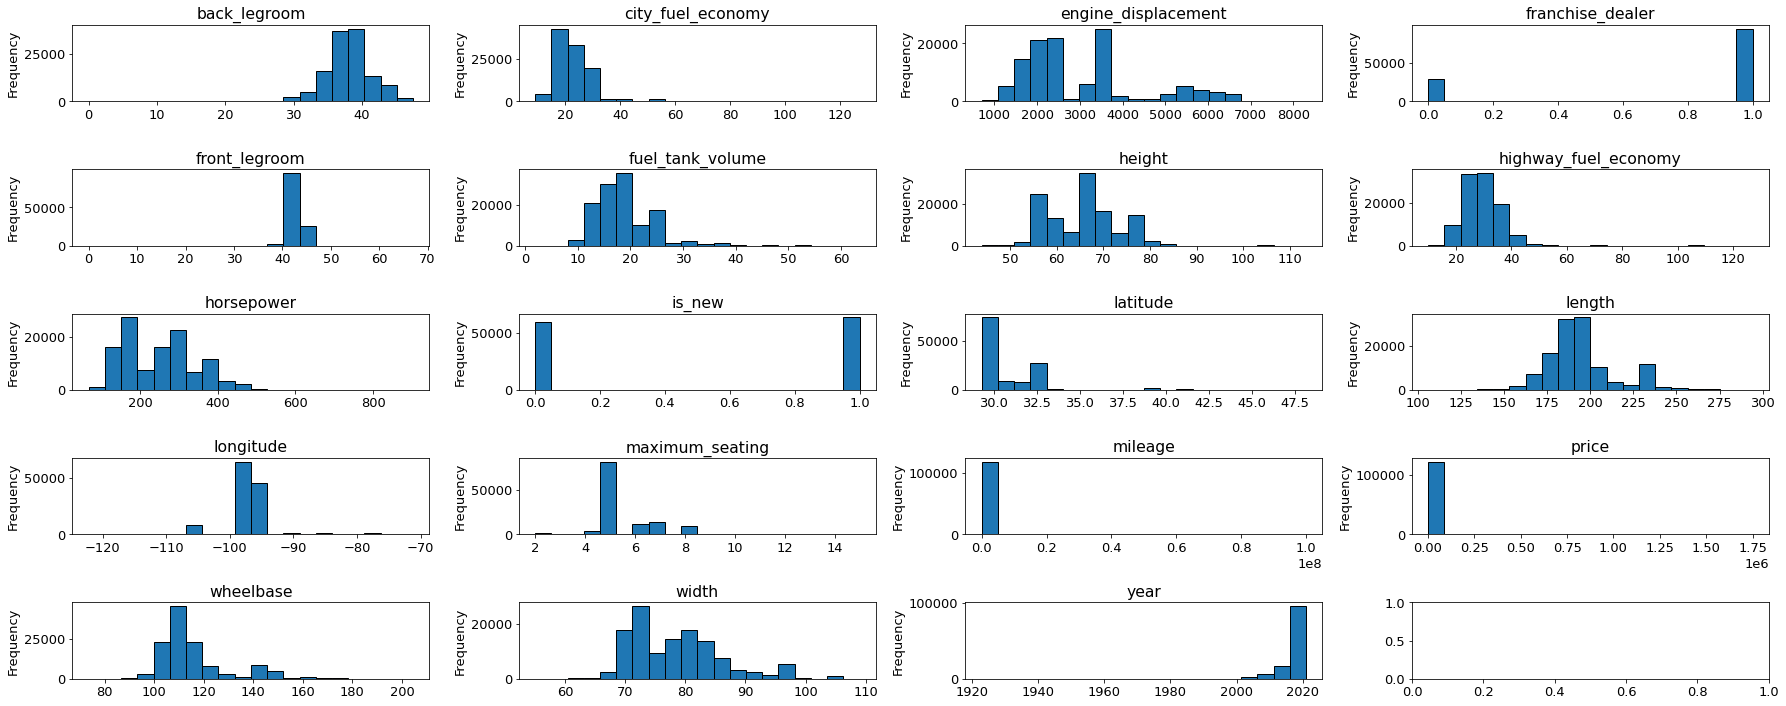

In [764]:
# take a look at remaining column distributions
# let's take a look at the distributions of the continuous variables
fig, axs = plt.subplots(5, 4, sharey=False, figsize=(25, 10))
axe = axs.ravel()
for i, c in enumerate(df.select_dtypes('number').columns):
    df[c].plot.hist(ax=axe[i],title=c, ec='black', bins=20)
    plt.tight_layout()

#### Categorical 

In [765]:
len(df.select_dtypes('object').columns.tolist())

7

In [766]:
cat_cols = df.select_dtypes('object').columns.tolist()

In [767]:
for cat in cat_cols:
    print(cat)
    print('-----------------')
    print(df[cat].value_counts(normalize=True))
    print('-----------------')


body_type
-----------------
SUV / Crossover    0.459508
Sedan              0.264546
Pickup Truck       0.162026
Coupe              0.030624
Hatchback          0.027861
Minivan            0.024527
Van                0.010968
Wagon              0.010845
Convertible        0.009096
Name: body_type, dtype: float64
-----------------
city
-----------------
Houston        0.356289
San Antonio    0.203101
Dallas         0.119211
Austin         0.115783
El Paso        0.079126
Arlington      0.069616
Fort Worth     0.056874
Name: city, dtype: float64
-----------------
fuel_type
-----------------
Gasoline                  0.896035
Flex Fuel Vehicle         0.051677
Hybrid                    0.023830
Diesel                    0.015663
Biodiesel                 0.008838
Electric                  0.003916
Compressed Natural Gas    0.000042
Name: fuel_type, dtype: float64
-----------------
listing_color
-----------------
WHITE      0.220378
BLACK      0.199583
UNKNOWN    0.139282
SILVER     0.130423

---
#### Bool 
---

In [768]:
len(df.select_dtypes('bool').columns.tolist())

0

In [769]:
bool_cols = df.select_dtypes('bool').columns.tolist()

In [770]:
for col in bool_cols:
    print(col)
    print('-----------------')
    print(df[col].value_counts(normalize=True))
    print('-----------------')